<a href="https://colab.research.google.com/github/modichirag/galmodel/blob/u%2FEiffL%2FCosmicRIM/notebooks/CosmicRIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/artix41/RIM-pytorch/blob/master/rim-toy.ipynb

https://github.com/wmorning/DeepClean

## Installing dependencies


In [1]:
!pip install git+https://github.com/modichirag/flowpm.git@u/EiffL/ops
!git clone https://github.com/modichirag/flowpm.git 
!git clone https://github.com/modichirag/galmodel.git -b u/EiffL/CosmicRIM

  Cloning https://github.com/modichirag/flowpm.git (to revision u/EiffL/ops) to /tmp/pip-req-build-zx76zh9u
  Running command git clone -q https://github.com/modichirag/flowpm.git /tmp/pip-req-build-zx76zh9u
  Running command git checkout -b u/EiffL/ops --track origin/u/EiffL/ops
  Switched to a new branch 'u/EiffL/ops'
  Branch 'u/EiffL/ops' set up to track remote branch 'u/EiffL/ops' from 'origin'.
  Created wheel for flowpm: filename=flowpm-0.1-cp36-none-any.whl size=11269 sha256=9d72253fdf775b3cb3c98195f0a450bced9f2b002f4d3f028d395a0d644bd895
  Stored in directory: /tmp/pip-ephem-wheel-cache-0jbp0hgs/wheels/a7/cf/46/38a5d061a8e3218031be48fd77d3c4c096624b1b1497197fe3
Successfully built flowpm
Cloning into 'flowpm'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 227 (delta 128), reused 147 (delta 59), pack-reused 0
Receiving objects: 100% (227/227), 155.22 KiB | 873.00 KiB/s, d

In [0]:
import sys
sys.path.insert(0,'galmodel/')

## Moving on to the main business

In [2]:
%pylab inline
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

Populating the interactive namespace from numpy and matplotlib


In [0]:
import tensorflow as tf

import flowpm
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline

klin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[1]

ipklin = iuspline(klin, plin)

### Build data pipeline

In [4]:
# Parameters of the simulations
a0 = 0.1
stages = np.linspace(a0, 1.0, 2, endpoint=True)
boxsize = 100
nc = 16
batch_size = 16

def sample_sim(dummy):
  """ Draws a batch of realizations of initial cond
  """
  initial_conditions = flowpm.linear_field(nc, boxsize, ipklin, batch_size=batch_size)
  state = flowpm.lpt_init(initial_conditions, a0=a0)
  final_state = flowpm.nbody(state, stages, nc)
  final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])
  return initial_conditions, final_field

dset = tf.data.Dataset.range(10)
dset = dset.map(sample_sim)
dset = dset.apply(tf.data.experimental.unbatch())
dset = dset.prefetch(-1)

In [5]:
it = dset.make_initializable_iterator()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


In [0]:
sess = tf.Session()
sess.run(it.initializer)

In [0]:
res = sess.run(it.get_next())

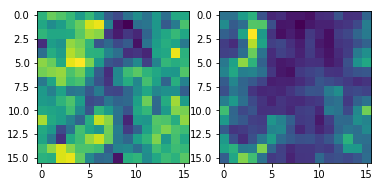

In [8]:
subplot(121)
imshow(res[0].sum(axis=0))
subplot(122)
imshow(res[1].sum(axis=0))

# Brute force Gradient Descent to check it works

In [0]:
sigma=1.0
tf.reset_default_graph()

def pm(lin):
  state = flowpm.lpt_init(lin, a0=a0)
  final_state = flowpm.nbody(state, stages, nc)
  final_field = flowpm.cic_paint(tf.zeros_like(lin), final_state[0])
  return final_field

xx = tf.placeholder(tf.float32, [1, nc, nc, nc])
yy = tf.placeholder(tf.float32, [1, nc, nc, nc])

linear = tf.get_variable('linmesh', shape=(1, nc, nc, nc),
            initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
initlin_op = linear.assign(xx, name='initlin_op')

final = pm(linear)

likelihood = tf.subtract(final, tf.squeeze(yy))
residual = tf.multiply(likelihood, 1./sigma)
chisq = tf.multiply(residual, residual)
chisq = tf.reduce_sum(chisq)
chisq = tf.multiply(chisq, 1/nc**3, name='chisq')

logposterior = chisq
# grads = tf.gradients(logposterior, [linear])[0]

opt = tf.train.AdamOptimizer(learning_rate=0.1)
grads = opt.compute_gradients(logposterior, [linear])
applygrads = opt.apply_gradients(grads)

In [0]:
start = time.time()
#Train

# with tf.Session() as sess:
sess = tf.Session()    
sess.run(tf.global_variables_initializer())

dset = tf.data.Dataset.range(10)
dset = dset.map(sample_sim)
dset = dset.apply(tf.data.experimental.unbatch())
dset = dset.prefetch(-1)
it = dset.make_initializable_iterator()
sess.run(it.initializer)

batchsize = 1
ixx, iyy = sess.run(it.get_next())

for i in range(100):
    _ = sess.run(applygrads, {xx:ixx.reshape((1, nc,nc,nc)),
                              yy:iyy.reshape((1, nc,nc,nc))})

print(time.time()-start)

21.36795926094055


In [0]:
test = sess.run(linear, {xx:ixx.reshape((1, nc,nc,nc)), 
                         yy:iyy.reshape((1, nc,nc,nc))})

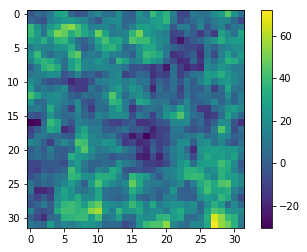

In [0]:
plt.imshow(test[0].sum(axis=0)); colorbar()

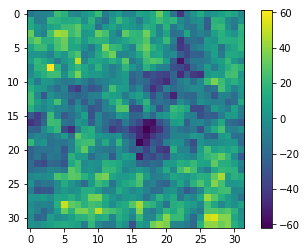

In [0]:
plt.imshow(ixx.sum(axis=0)); colorbar()

# RIM

In [0]:
from galmodel.layers.recurrent_inference import ConvRIM3D
from galmodel.layers.convolutional_recurrent import ConvLSTM3DCell

def pm(lin):
  state = flowpm.lpt_init(lin, a0=a0)
  final_state = flowpm.nbody(state, stages, nc)
  final_field = flowpm.cic_paint(tf.zeros_like(lin), final_state[0])
  return final_field

def likelihood_fn(inputs, predictions):
  """ Evaluates the data likelihood function through Fast PM
  """
  final_field = pm(predictions[..., 0])
  likelihood = tf.reduce_mean((final_field - inputs[...,0])**2/sigma**2, 
                              axis=[1, 2, 3])
  return likelihood

In [0]:
tf.reset_default_graph()

sigma=1.0/nc**3

# Building blocks of the RIM
cell = ConvLSTM3DCell(filters=128, kernel_size=3, padding='SAME')
output_layer = tf.keras.layers.Conv3D(filters=1, kernel_size=3, padding='SAME')


# Instantiate the cosmic rim
cosmic_rim = ConvRIM3D(cell,
                       output_layer,
                       likelihood_fn=likelihood_fn,
                       niter=10, 
                       return_sequences=True)

In [15]:
xx = tf.placeholder(tf.float32, [batch_size, nc, nc, nc, 1])
yy = tf.placeholder(tf.float32, [batch_size, nc, nc, nc, 1])
lr = tf.placeholder(tf.float32)

# axis 0 is the iteration number
preds = cosmic_rim(yy)

# Compute the final field at the end of the reconstruction
fin = pm(preds[-1,...,0])

batch_loss = tf.reduce_mean((preds - xx)**2, axis=[0, 2, 3, 4, 5])

loss = tf.reduce_mean(batch_loss)

opt = tf.train.GradientDescentOptimizer(learning_rate=lr)

opt_op = opt.minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Tensor("conv_ri_m3d/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 16, 16, 16, 16, 128), dtype=float32)


In [0]:
dset = tf.data.Dataset.range(10000)
dset = dset.map(sample_sim)
dset = dset.apply(tf.data.experimental.unbatch())
# dset = dset.cache()
# dset = dset.repeat()
# dset = dset.shuffle(1000)
dset = dset.batch(16)
dset = dset.prefetch(-1)
it = dset.make_initializable_iterator()
infield, outfield = it.get_next()

In [17]:
start = time.time()

sess = tf.Session()    
sess.run(tf.global_variables_initializer())
sess.run(it.initializer)

llist = []

for nb in range(2):
  ixx, iyy = sess.run([infield, outfield])
  _, l,  = sess.run([opt_op, loss], {xx:ixx.reshape((batch_size, nc, nc, nc, 1)),
                                      yy:iyy.reshape((batch_size, nc, nc, nc, 1)),
                                      lr:0.001})
  print('Step : ', nb, ' Loss : ', l)
  llist.append(l)

print(time.time()-start)

Step :  0  Loss :  2.3681746
Step :  1  Loss :  2.125667
21.766587257385254


In [65]:
for nb in range(500):
  ixx, iyy = sess.run([infield, outfield])
  _, l,  = sess.run([opt_op, loss], {xx:ixx.reshape((batch_size, nc, nc, nc, 1)),
                                      yy:iyy.reshape((batch_size, nc, nc, nc, 1)),
                                      lr:0.0002})
  print('Step : ', nb, ' Loss : ', l)
    
  llist.append(l)

print(time.time()-start)

Step :  0  Loss :  1.5457795
Step :  1  Loss :  1.526641
Step :  2  Loss :  1.5632703
Step :  3  Loss :  1.5288588
Step :  4  Loss :  1.5492523
Step :  5  Loss :  1.5676928
Step :  6  Loss :  1.5711246
Step :  7  Loss :  1.589958
Step :  8  Loss :  1.5642594
Step :  9  Loss :  1.5559726
Step :  10  Loss :  1.5477997
Step :  11  Loss :  1.51882
Step :  12  Loss :  1.5479525
Step :  13  Loss :  1.5423504
Step :  14  Loss :  1.5498736
Step :  15  Loss :  1.5961416
Step :  16  Loss :  1.5647224
Step :  17  Loss :  1.5017972
Step :  18  Loss :  1.554409
Step :  19  Loss :  1.551606
Step :  20  Loss :  1.5725749
Step :  21  Loss :  1.5540048
Step :  22  Loss :  1.5755386
Step :  23  Loss :  1.5604669
Step :  24  Loss :  1.565875
Step :  25  Loss :  1.5393236
Step :  26  Loss :  1.5537381
Step :  27  Loss :  1.5223681
Step :  28  Loss :  1.5688207
Step :  29  Loss :  1.5024948
Step :  30  Loss :  1.5234137
Step :  31  Loss :  1.5362023
Step :  32  Loss :  1.5232278
Step :  33  Loss :  1.57458

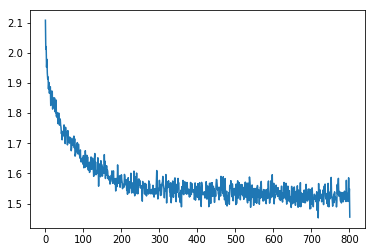

In [66]:
plt.plot(llist[2:])

In [0]:
ixx, iyy = sess.run([infield, outfield])
steps, rec = sess.run([preds, fin], {xx:ixx.reshape((batch_size, nc, nc, nc, 1)),
                        yy:iyy.reshape((batch_size, nc, nc, nc, 1)),
                                      lr:0.001})

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


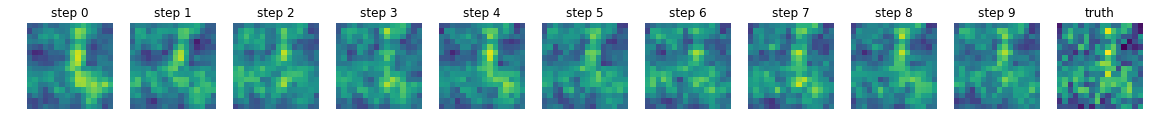

In [68]:
ii = 4
ref = np.squeeze(ixx[ii]).sum(axis=0)

figure(figsize=(20,4))
for i in range(10):
  subplot(1,11,i+1)
  imshow(np.squeeze(steps[i][ii]).sum(axis=0), vmin=ref.min(), vmax=ref.max())
  axis('off')
  title('step %d'%i)

  subplot(1,11,11)
  imshow(ref, vmin=ref.min(), vmax=ref.max())
  title('truth')
  axis('off')

Text(0.5, 1.0, 'final field')

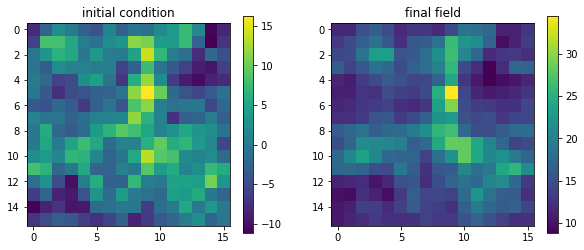

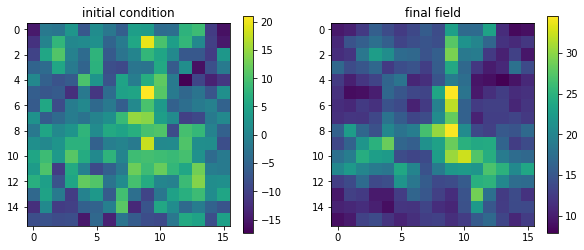

In [69]:
figure(figsize=(10,4))
subplot(121)
imshow(np.squeeze(steps[-1][ii]).sum(axis=0))
title('initial condition')

colorbar()
subplot(122)
imshow(np.squeeze(rec[ii]).sum(axis=0))
colorbar()

title('final field')

figure(figsize=(10,4))
subplot(121)
imshow(np.squeeze(ixx[ii]).sum(axis=0))
colorbar()
title('initial condition')

subplot(122)
imshow(np.squeeze(iyy[ii]).sum(axis=0))
colorbar()
title('final field')